In [1]:
import os, sys, glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np

import mne

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def unfold_raw(raw, window_size=None, stride=None):
    """
    This function unfolds raw MNE object into a list of raw objects
    Args:
        raw: a raw MNE object cropped by rejecting bad segments.
    Returns:
        raw_unfolded: a raw MNE object unfolded by applying a sliding window.
    """
    if window_size is None:
        window_size = int(5 * raw.info['sfreq'])
    if stride is None:
        stride = window_size
    nchans = len(raw.ch_names)
    sig = torch.tensor(raw.get_data(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sig_unf = F.unfold(sig, (nchans, window_size), stride=stride , padding=0)
    sig_unf = sig_unf.permute(0, 2, 1).reshape(-1, sig_unf.shape[-1], nchans, window_size)
    return sig_unf

In [3]:
def rm_repeated_annotations(raw):
    """This functions taskes in raw MNE obejct and removes repeated annotations"""
    annots = raw.annotations.copy()
    annots_drop = []
    for k in annots:
        annots_drop.extend([k for kk in annots if (k['onset'] > kk['onset']) and (k['onset']+k['duration'] < kk['onset']+kk['duration']) ])

    annots_updated = [i for i in annots if i not in annots_drop]
    onsets = [i['onset'] for i in annots_updated]
    durations = [i['duration'] for i in annots_updated]
    descriptions = [i['description'] for i in annots_updated]
    print('Initial num of annots: %d  Num of removed annots: %d  Num of retained annots:  %d' % (len(annots), len(annots_drop), len(annots_updated)))
    print(f' New annots: {annots_updated}')
    raw.set_annotations(mne.Annotations(onsets, durations, descriptions) ) 
    return raw

## Read Data

In [4]:
subj_ids = [1, 2]
fs = 128
window_size = int(5 * fs)
stride_size_train, stride_size_val, stride_size_test = int(2.5 * fs), int(2.5 * fs), int(2.5 * fs)
n_channs = 129 # 128 for eeg, 1 for env
batch_size = 64
print('-------------------------------------')
print(f'window_size: {window_size}  stride_size_test: {stride_size_test}')

dataset_name = ['rochester_data', 'natural_speech']
outputs_path = f'../outputs/'
data_path = os.path.join(outputs_path, dataset_name[0], dataset_name[1])
print(f'data_path: {data_path}')

-------------------------------------
window_size: 640  stride_size_test: 320
data_path: ../outputs/rochester_data/natural_speech


In [5]:
raws_train_windowed, raws_val_windowed, raws_test_windowed = [], [], []

for subj_id in subj_ids:
    subj_path = os.path.join(data_path, f'subj_{subj_id}')

    # load subject raw MNE object
    raw = mne.io.read_raw(os.path.join(subj_path, 'after_ica_raw.fif'), preload=True)
    # drop M1 and M2 channels
    raw.drop_channels(['M1', 'M2'])
    assert raw.info['nchan'] == n_channs

    raw = rm_repeated_annotations(raw)
    annots = raw.annotations.copy()
    raw_split = [raw.copy().crop(t1, t2) for t1, t2 in zip(annots.onset[:-1]+annots.duration[:-1], annots.onset[1:])]

    # Pick the split with the longest duration for validation, supposedly less noisy
    ix_val = np.argmax([i.get_data().shape[1] for i in raw_split])
    raw_val = [raw_split.pop(ix_val)] # create a list to make it iterable. later may be used for multiple splits

    # Pick the next split with the longest duration for testing, supposedly less noisy
    ix_test = np.argmax([i.get_data().shape[1] for i in raw_split])
    raw_test = [raw_split.pop(ix_test)]
    
    # creat list of unfolded tensor raw objects
    fs = raw.info['sfreq']
    raws_train_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_train) for i in raw_split if i.get_data().shape[1] > window_size])
    raws_val_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_val) for i in raw_val if i.get_data().shape[1] > window_size])
    raws_test_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_test) for i in raw_test if i.get_data().shape[1] > window_size])
    print("-------------------------------------")
    print('N train: %d  N val: %d  N test: %d' % (len(raws_train_windowed), len(raws_val_windowed), len(raws_test_windowed)))

# concatenate all in second dimension
sigs_train = torch.cat(raws_train_windowed, dim=1).permute(1, 0, 2, 3)
sigs_val = torch.cat(raws_val_windowed, dim=1).permute(1, 0, 2, 3)
sigs_test = torch.cat(raws_test_windowed, dim=1).permute(1, 0, 2, 3)
print(f"Shape Trian: {sigs_train.shape}  Shape Val: {sigs_val.shape}  Shape Test: {sigs_test.shape}")

eegs_train = sigs_train[:, :, :-1, :]
eegs_val = sigs_val[:, :, :-1, :]
eegs_test = sigs_test[:, :, :-1, :]
print("-------------------------------------")
print(f"Shape EEG Train: {eegs_train.shape}  Val: {eegs_val.shape}  Test: {eegs_test.shape}")

# To avoid information leakage, we estimate the mean and std from the training set only.
mean_eeg_train =  eegs_train.mean()
std_eeg_train = eegs_train.std()
print(f"Mean: {mean_eeg_train}  Std: {std_eeg_train}")

envs_train = sigs_train[:, :, [-1], :]
envs_val = sigs_val[:, :, [-1], :]
envs_test = sigs_test[:, :, [-1], :]
print(f"Shape Env Train: {envs_train.shape}  Val: {envs_val.shape}  Test: {envs_test.shape}")

# Estimate mean and std of the Envelope data set
mean_env_train =  envs_train.mean()
std_env_train = envs_train.std()
print(f"Mean Env: {mean_env_train}  Std Env: {std_env_train}")

# Normalize the data
eegs_train = (eegs_train - mean_eeg_train) / std_eeg_train
eegs_val = (eegs_val - mean_eeg_train) / std_eeg_train
eegs_test = (eegs_test - mean_eeg_train) / std_eeg_train

envs_train = (envs_train - mean_env_train) / std_env_train
envs_val = (envs_val - mean_env_train) / std_env_train
envs_test = (envs_test - mean_env_train) / std_env_train



Opening raw data file ../outputs/rochester_data/natural_speech/subj_1/after_ica_raw.fif...
    Range : 0 ... 464571 =      0.000 ...  3629.461 secs
Ready.
Reading 0 ... 464571  =      0.000 ...  3629.461 secs...
Initial num of annots: 42  Num of removed annots: 19  Num of retained annots:  23
 New annots: [OrderedDict([('onset', 0.0), ('duration', 0.0), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 176.784332), ('duration', 2.0346832275390625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 357.548248), ('duration', 1.66888427734375), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 537.407166), ('duration', 1.8746337890625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 719.272339), ('duration', 0.75445556640625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 899.217163), ('duration', 1.8060302734375), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset',

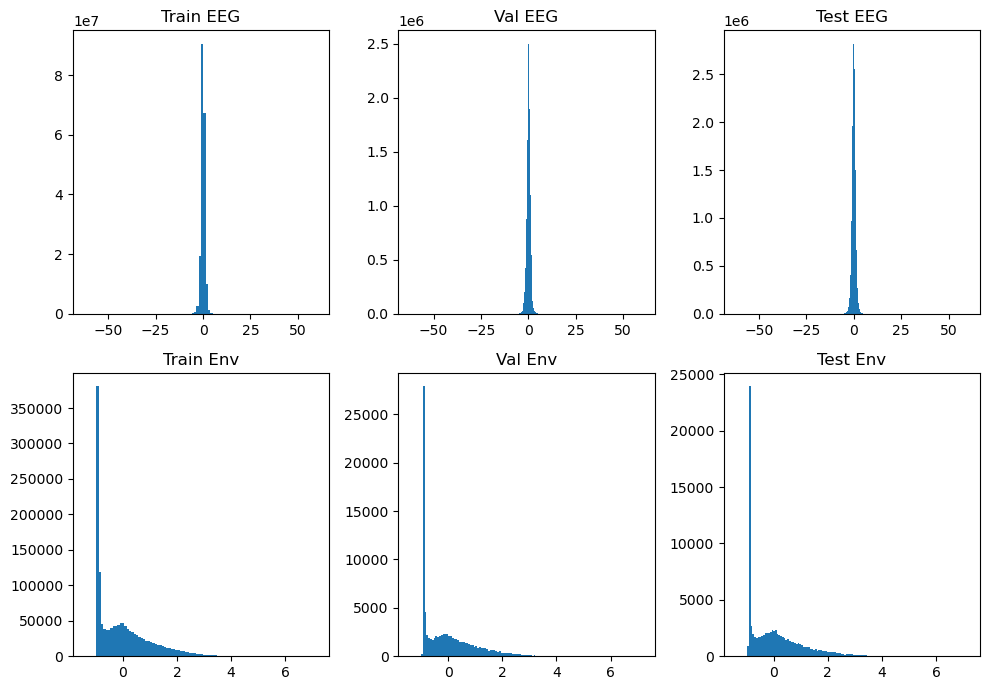

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7), sharex='row')
ax[0, 0].hist(eegs_train.flatten().numpy(), bins=100);
ax[0, 0].set_title('Train EEG')
ax[0, 1].hist(eegs_val.flatten().numpy(), bins=100);
ax[0, 1].set_title('Val EEG')
ax[0, 2].hist(eegs_test.flatten().numpy(), bins=100);
ax[0, 2].set_title('Test EEG')
ax[1, 0].hist(envs_train.flatten().numpy(), bins=100);
ax[1, 0].set_title('Train Env')
ax[1, 1].hist(envs_val.flatten().numpy(), bins=100);
ax[1, 1].set_title('Val Env')
ax[1, 2].hist(envs_test.flatten().numpy(), bins=100);
ax[1, 2].set_title('Test Env')
plt.tight_layout()
plt.show();

### Pytorch dataloader

In [7]:
class MyDataset(Dataset):
    def __init__(self, eeg, env):
        self.eeg = eeg
        self.env = env
    
    def __getitem__(self, index):
        return self.eeg[index], self.env[index]
    
    def __len__(self):
        return len(self.eeg)
    
dataset_train = MyDataset(eegs_train, envs_train)
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

## Model

In [8]:
class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, **kargs):
        super().__init__(in_channels, out_channels, kernel_size, **kargs)

    def __call__(self, inp):
        self.out = super().__call__(inp)

        if self.out.requires_grad:
            self.out.retain_grad()

        return self.out
    
    # -----------------------------------------------------------------------------------------------
class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
  # -----------------------------------------------------------------------------------------------
class Linear(nn.Linear):
    def __init__(self, x, y, **kargs):
        super().__init__(x, y, **kargs)

    def __call__(self, inp):
        self.out = super().__call__(inp)
        return self.out
  # -----------------------------------------------------------------------------------------------
   
class ELU(nn.ELU):
    def __init__(self, alpha=1.0, inplace=False):
        super().__init__(alpha=1.0, inplace=False)

    def __call__(self, inp):
        self.out = super().__call__(inp)
        if self.out.requires_grad:
            self.out.retain_grad()
        return self.out

  # -----------------------------------------------------------------------------------------------
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

    def named_parameters(self):
        # get parameters of all layers and stretch them out into one list
        return ((n, p) for layer in self.layers for n, p in layer.named_parameters())

In [48]:
# My implementation of the shallow convnet

fs = 64 # sampling rate
T = 5 * fs # number of time points in each trial
C = 64 # number of EEG channels
F1 = 8 # number of channels (depth) in the first conv layer
D = 2 # number of spatial filters in the second conv layer
F2 = D * F1 # number of channels (depth) in the pont-wise conv layer
num_classes = 4 # number of classes

shallow_covnet = Sequential([
    Conv2d(1, 40, (1, int(fs//2)), padding='same', bias=True),
    Conv2d(40, 40, (C, 1), padding=(0, 0), bias=False), nn.BatchNorm2d(40, affine=True), 
    nn.AvgPool2d((1, 75), (1, 15)), nn.Dropout(0.5),
    Conv2d(40, 4, kernel_size=(1, 30), padding='same', stride=(1, 1), bias=True),
    nn.Flatten(1, -1), # Flatten start_dim=1, end_dim=-1
    Linear(62*4, 4, bias=True),
])



In [59]:

class EEGEncoder(nn.Module):
    def __init__(self,             
            fs = 128, # sampling rate
            T = 5, # lenght of each trial in seconds
            C = 128, # number of EEG channels
            F1 = 4, # number of channels (depth) in the first conv layer
            D = 2, # number of spatial filters in the second conv layer
            F2 = None # number of channels (depth) in the pont-wise conv layer
        ):
        super(EEGEncoder, self).__init__()

        if F2 is None:
            F2 = D * F1

        self.eeg_encoder = nn.Sequential(
            Conv2d(1, F1, (1, int(fs/2)), padding='same', bias=True, groups=1),
            nn.BatchNorm2d(F1, affine=True),
            Conv2d(F1, out_channels=D*F1, kernel_size=(C, 1), padding=(0, 0), bias=False, groups=F1),

            nn.BatchNorm2d(D*F1, affine=True), ELU(), nn.AvgPool2d(1, 2), nn.Dropout(0.5),
                    
            Conv2d(F2, F2, (1, int(fs/(2*4))), padding='same', bias=False, groups=D*F1),
            nn.BatchNorm2d(F2, affine=True),
            Conv2d(D*F1, F2, kernel_size=(1, 1), padding=(0, 0), groups=1, bias=False),
            nn.BatchNorm2d(F2, affine=True), ELU(), nn.AvgPool2d(1, 4), nn.Dropout(0.5),

            nn.Flatten(),
            nn.Linear(F2*int((T*fs)//(2*4)), fs)
        ) 

    @torch.no_grad()
    def normalize_weights_eegnet(self):

        for name, param in self.eeg_encoder.named_parameters():
            if  name == 'weight' and param.ndim==4: # normalize conv weights to max norm 1
                param.data = torch.renorm(param.data, 2, 0, maxnorm=1)
                #param.data /=  eps + param.data.norm(2, dim=0, keepdim=True)
            elif name == 'weight' and param.ndim==2: # normalize fc weights to max norm 0.25
                param.data = torch.renorm(param.data, 2, 0, maxnorm=0.25)
                #param.data /=  eps + param.data.norm(2, dim=0, keepdim=True)


    def forward(self, x):
        x = self.eeg_encoder(x)
        return x

eeg_encoder = EEGEncoder()
eeg_encoder.eeg_encoder

# Test the model, add no grad
with torch.no_grad():
    print(eeg_encoder(eegs_train[:32, :, :, :]).shape)

torch.Size([32, 128])


In [60]:
class EnvEncoder(nn.Module):

    def __init__(self,             
            fs = 128, # sampling rate
            T = 5, # lenght of each trial in seconds
            F1 = 4
        ):
        super(EnvEncoder, self).__init__()

        self.env_encoder = nn.Sequential(
            Conv2d(1, F1, (1, int(fs//2)), padding='same', bias=True),
            nn.BatchNorm2d(F1, affine=True), ELU(), nn.AvgPool2d(1, 2), nn.Dropout(0.5),
            Conv2d(F1, F1, (1, int(fs//8)), padding='same', bias=False, groups=F1),
            nn.BatchNorm2d(F1, affine=True), ELU(), nn.AvgPool2d(1, 4), nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(F1*int((T*fs)//(2*4)), fs)
        ) 

    def forward(self, x):
        x = self.env_encoder(x)
        return x

env_encoder = EnvEncoder()
env_encoder.env_encoder

# Test the model, add no grad
with torch.no_grad():
    print(env_encoder(envs_train[:32, :, :, :]).shape)

torch.Size([32, 128])


In [61]:
class CES(nn.Module):
    def __init__(self, 
                 eeg_encoder= eeg_encoder.eeg_encoder,
                 env_encoder = env_encoder.env_encoder): 
        super().__init__()

        self.eeg_encoder = eeg_encoder
        self.env_encoder = env_encoder
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def encode_eeg(self, x):
        return self.eeg_encoder(x)
    
    def encode_env(self, x):
        return self.env_encoder(x)
    
    def forward(self, eeg, env):
        eeg_features = self.encode_eeg(eeg)
        env_features = self.encode_env(env)
        return eeg_features, env_features, self.logit_scale.exp()
  

model = CES()
for n,p in model.named_parameters():
    print(n, p.shape)


logit_scale torch.Size([])
eeg_encoder.0.weight torch.Size([4, 1, 1, 64])
eeg_encoder.0.bias torch.Size([4])
eeg_encoder.1.weight torch.Size([4])
eeg_encoder.1.bias torch.Size([4])
eeg_encoder.2.weight torch.Size([8, 1, 128, 1])
eeg_encoder.3.weight torch.Size([8])
eeg_encoder.3.bias torch.Size([8])
eeg_encoder.7.weight torch.Size([8, 1, 1, 16])
eeg_encoder.8.weight torch.Size([8])
eeg_encoder.8.bias torch.Size([8])
eeg_encoder.9.weight torch.Size([8, 8, 1, 1])
eeg_encoder.10.weight torch.Size([8])
eeg_encoder.10.bias torch.Size([8])
eeg_encoder.15.weight torch.Size([128, 640])
eeg_encoder.15.bias torch.Size([128])
env_encoder.0.weight torch.Size([4, 1, 1, 64])
env_encoder.0.bias torch.Size([4])
env_encoder.1.weight torch.Size([4])
env_encoder.1.bias torch.Size([4])
env_encoder.5.weight torch.Size([4, 1, 1, 16])
env_encoder.6.weight torch.Size([4])
env_encoder.6.bias torch.Size([4])
env_encoder.11.weight torch.Size([128, 320])
env_encoder.11.bias torch.Size([128])


## Model Setup

## Optimization

In [62]:

with torch.no_grad():
    for ix, layer in enumerate(model.eeg_encoder + model.env_encoder):
        if isinstance(layer, nn.Conv2d):
            layer.weight *= 0.01
            if layer.bias is not None:
                layer.bias *= 0


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
    p.requires_grad = True

print(model.eeg_encoder)
print(model.env_encoder)



125009
Sequential(
  (0): Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), padding=same)
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(4, 8, kernel_size=(128, 1), stride=(1, 1), groups=4, bias=False)
  (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ELU(alpha=1.0)
  (5): AvgPool2d(kernel_size=1, stride=2, padding=0)
  (6): Dropout(p=0.5, inplace=False)
  (7): Conv2d(8, 8, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=8, bias=False)
  (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ELU(alpha=1.0)
  (12): AvgPool2d(kernel_size=1, stride=4, padding=0)
  (13): Dropout(p=0.5, inplace=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=640, out_features=128, bias=True)

In [63]:
print(f" Number of parameters: {sum(p.nelement() for p in model.parameters())}") # number of parameters in total
print(f" Shape EEG: {dataloader.dataset.eeg.shape}   Env: {dataloader.dataset.env.shape}")
print(f" Batch size: {dataloader.batch_size}")
print(f" Number of batches: {len(dataloader)}")

 Number of parameters: 125009
 Shape EEG: torch.Size([2342, 1, 128, 640])   Env: torch.Size([2342, 1, 1, 640])
 Batch size: 64
 Number of batches: 36


# gradient not getting updateing
maybe because the chain removes the referencing ...

links to check for implementing the loss function:  

https://www.kaggle.com/code/moeinshariatnia/openai-clip-simple-implementation/notebook  


https://github.com/openai/CLIP/issues/83


https://github.com/mlfoundations/open_clip

https://github.com/mlfoundations/open_clip/blob/main/src/open_clip/loss.py

In [64]:
sys.getsizeof(eegs_train.storage())/1e6

767.426608

In [69]:
num_train = eegs_train.shape[0]
max_steps = 100
lossi = []
udri = [] # update / data ratio 
ud = []

for epoch in range(1, 20):

    model.train()
    for ix_batch, (Xb_eeg, Xb_env) in enumerate(dataloader):

        # forward pass
        eeg_features, env_features, logit_scale = model(Xb_eeg, Xb_env) 

        # normalize features
        eeg_features_n = eeg_features / eeg_features.norm(dim=1, keepdim=True)
        env_features_n = env_features / env_features.norm(dim=1, keepdim=True)

        # logits
        logits_per_eeg = logit_scale * eeg_features_n @ env_features_n.t()
        logits_per_env = logits_per_eeg.t()

        #loss function
        labels = torch.arange(batch_size)
        loss_eeg = F.cross_entropy(logits_per_eeg, labels)
        loss_env = F.cross_entropy(logits_per_env, labels)
        loss   = (loss_eeg + loss_env)/2

        # backward pass
        for p in model.parameters():
            p.grad = None
        loss.backward()

        # update: simple SGD
        lr = 0.005 if epoch < 50 else 0.001 # step learning rate decay
        for p in model.parameters():
            p.data += -lr * p.grad

        # normalize weights
        #with torch.no_grad():
        #    normalize_weights_eegnet(eeg_encoder)
        #with torch.no_grad():
        #    model.eeg_encoder.normalize_weights()

        # track stats
        if ix_batch % 5 == 0:
            print(f'Batch: {ix_batch:7d}: {loss.item():.4f}  {loss_eeg.item():.4f}  {loss_env.item():.4f}   {eeg_features.detach().std().item():.4f}  {env_features.detach().std().item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in model.parameters() ])
        
        #break   

    #break
    # Validation after each epoch
    model.eval() # set the model in evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        eeg_f, env_f, logit_sc = model(eegs_val, envs_val)
        eeg_f_n = eeg_f / eeg_f.norm(dim=1, keepdim=True)
        env_f_n = env_f / env_f.norm(dim=1, keepdim=True)


        _logits_per_eeg = logit_sc * eeg_f_n @ env_f_n.t()
        _logits_per_env = _logits_per_eeg.t()
        #loss function
        _labels = torch.arange(eegs_val.shape[0])
        _loss_eeg = F.cross_entropy(_logits_per_eeg, _labels)
        _loss_env = F.cross_entropy(_logits_per_env, _labels)
        loss_val   = (_loss_eeg + _loss_env)/2
        print(f"====> Epoch: {epoch:3d}    Validation loss: {loss_val.item():.4f}")
    
    model.train()
            
    #break   


Batch:       0: 4.2388  4.2397  4.2380   0.6329  0.7012
Batch:       5: 4.4460  4.4453  4.4468   0.6340  0.6969
Batch:      10: 4.1662  4.1682  4.1642   0.6273  0.6820
Batch:      15: 4.3377  4.3382  4.3373   0.6384  0.6690
Batch:      20: 4.4105  4.4116  4.4093   0.6494  0.6960
Batch:      25: 4.3923  4.3934  4.3913   0.6235  0.6855
Batch:      30: 4.3456  4.3461  4.3451   0.6346  0.7095
Batch:      35: 4.2649  4.2645  4.2654   0.6412  0.7027
====> Epoch:   1    Validation loss: 5.1722
Batch:       0: 4.3753  4.3751  4.3756   0.6310  0.6964
Batch:       5: 4.2671  4.2674  4.2667   0.6292  0.7002
Batch:      10: 4.1974  4.1990  4.1958   0.6376  0.6968
Batch:      15: 4.3766  4.3775  4.3758   0.6277  0.6825
Batch:      20: 4.4178  4.4179  4.4177   0.6245  0.7027
Batch:      25: 4.2419  4.2441  4.2397   0.6325  0.6743
Batch:      30: 4.2672  4.2703  4.2642   0.6476  0.6795
Batch:      35: 4.2954  4.2953  4.2955   0.6325  0.6946
====> Epoch:   2    Validation loss: 5.1297
Batch:       0: 

layer 4 (       ELU):  mean  +0.162924, std 8.178962e-01, range [-9.998454e-01  8.481816e+00]
torch.Size([149, 8, 1, 640])
layer 11 (       ELU):  mean  +0.109054, std 6.403496e-01, range [-9.991721e-01  5.650121e+00]
torch.Size([149, 8, 1, 320])
layer 2 (       ELU):  mean  +0.152475, std 8.134950e-01, range [-9.885075e-01  5.336206e+00]
torch.Size([149, 4, 1, 640])
layer 7 (       ELU):  mean  +0.099768, std 6.455041e-01, range [-9.769855e-01  4.821715e+00]
torch.Size([149, 4, 1, 320])


AttributeError: 'NoneType' object has no attribute 'mean'

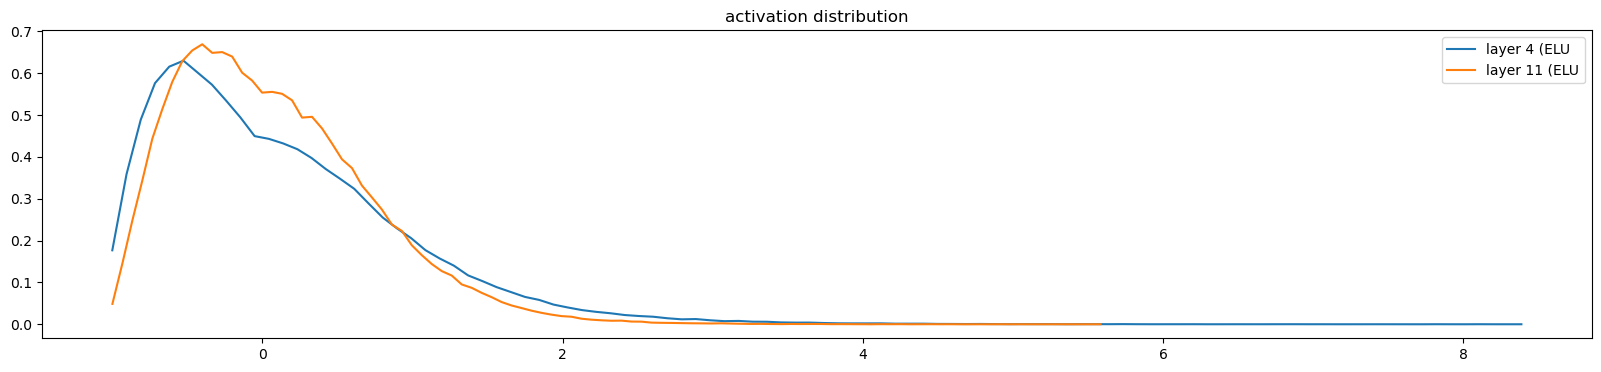

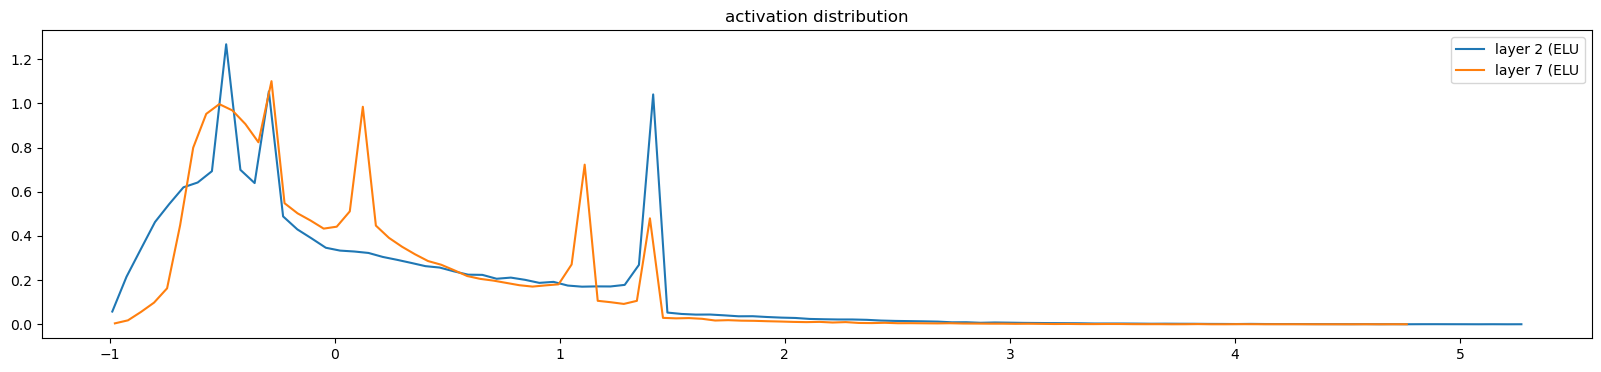

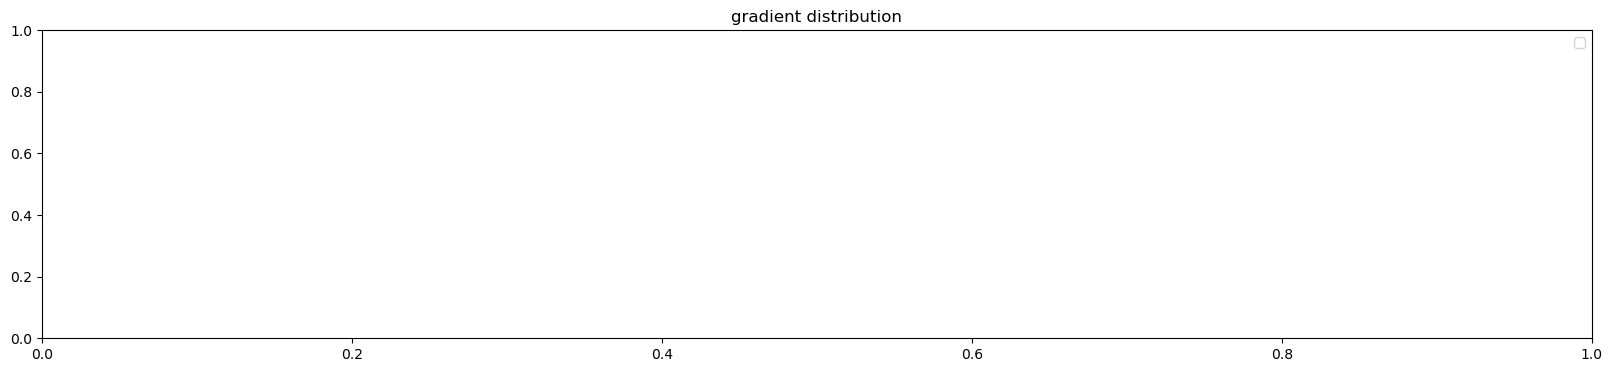

In [66]:
# ELU Activations and their gradients

plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (ELU)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')



plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (ELU)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, ELU):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, ELU):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


layer 0 (    Conv2d):  mean  +0.000292, std 1.491094e+00, range [-8.621138e+01  5.688367e+01]
torch.Size([149, 4, 128, 640])
layer 2 (    Conv2d):  mean  -0.000461, std 1.245223e+00, range [-1.252461e+01  1.210174e+01]
torch.Size([149, 8, 1, 640])
layer 7 (    Conv2d):  mean  +0.013261, std 2.070752e-01, range [-2.390671e+00  2.319974e+00]
torch.Size([149, 8, 1, 320])
layer 9 (    Conv2d):  mean  -0.001116, std 1.271977e-01, range [-1.117335e+00  1.003673e+00]
torch.Size([149, 8, 1, 320])
layer 0 (    Conv2d):  mean  +0.054476, std 3.045011e+00, range [-1.919747e+01  7.981432e+00]
torch.Size([149, 4, 1, 640])
layer 5 (    Conv2d):  mean  +0.039985, std 2.743200e-01, range [-1.245473e+00  1.871420e+00]
torch.Size([149, 4, 1, 320])


AttributeError: 'NoneType' object has no attribute 'mean'

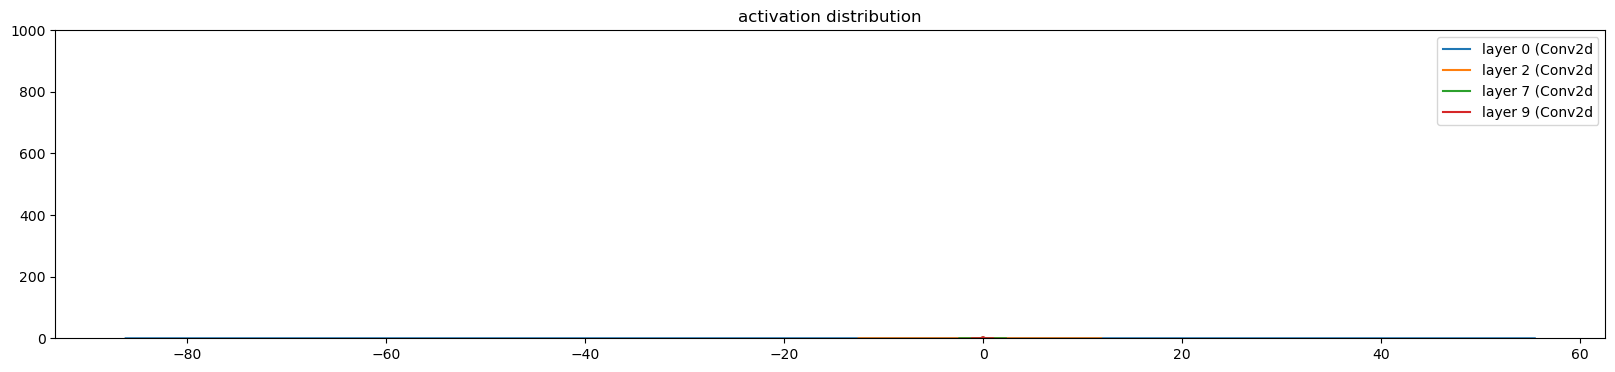

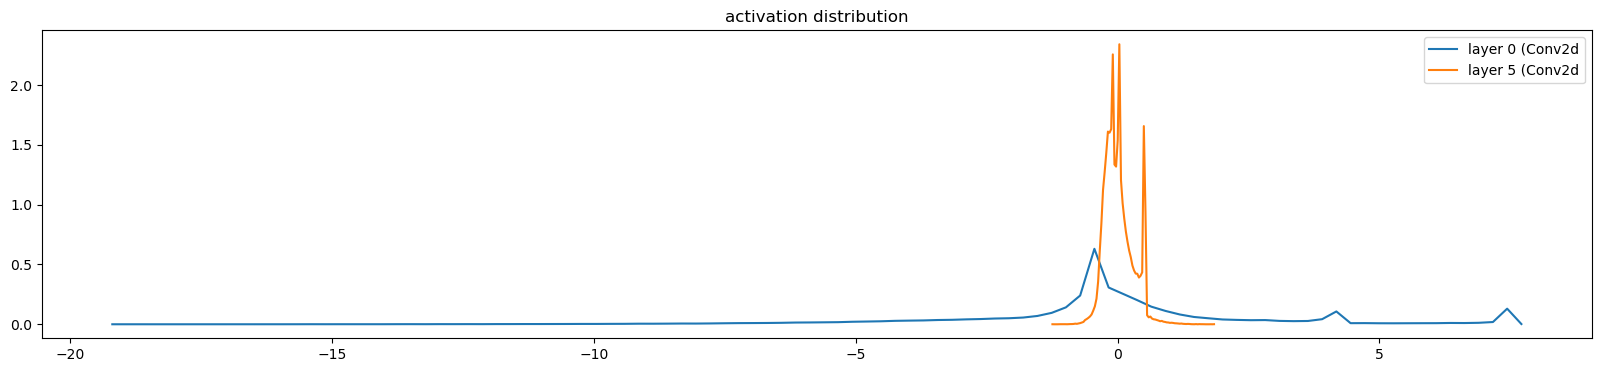

<Figure size 2000x400 with 0 Axes>

In [68]:
# Conv2d Activations and their gradients
if True:
    plt.figure(figsize=(20, 4)); # width and height of the plot
    legends = []
    for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, (Conv2d)):
            t = layer.out
            print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
            print(t.shape)
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            #plt.xlim(-.1, .1)
            plt.ylim(0, 1000)
            legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends);
        plt.title('activation distribution')

    plt.figure(figsize=(20, 4)); # width and height of the plot
    legends = []
    for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, (Conv2d)):
            t = layer.out
            print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
            print(t.shape)
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends);
        plt.title('activation distribution')


    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(model.eeg_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, Conv2d):
            t = layer.out.grad
            print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
        plt.legend(legends);
        plt.title('gradient distribution')


    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(model.env_encoder[:-1]): # note: exclude the output layer
        if isinstance(layer, Conv2d):
            t = layer.out.grad
            print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
        plt.legend(legends);
        plt.title('gradient distribution')



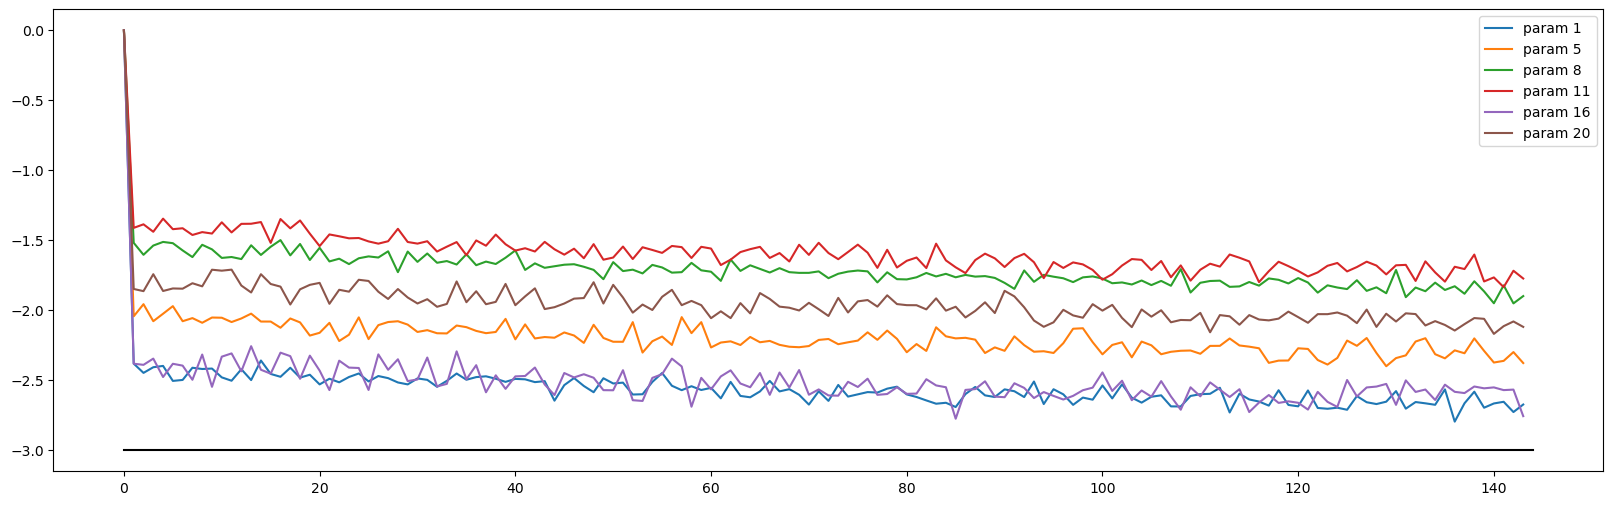

In [67]:
# Check the update / data ratio

plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 4:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these rations should be ~1e-3, indicate on plot.
plt.legend(legends);